#Tweets JSON Map Classification
This notebook maps the tweets that have been classified in the previous parsingTweets notebook by combining tweet geoinformation with classification predictions.

## Requirements

* PySpark
* Anaconda Python
* AWS Boto Python module
* Numpy

In [21]:
import json
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from PIL import ImageDraw
from IPython.display import display

In [17]:
#Read in the twitter predictions and the original tweetids
classifyJsonRDD = sc.textFile("tweetPredictions.txt")
tweetsRdd = sc.textFile("combined/*")
jsondict = tweetsRdd.map(lambda x: json.loads(x))

In [30]:
def checkId(idlist, idfield):
    for tweetid in idlist:
        if tweetid in idfield:
            return True
    return False

In [46]:
#print the json in a pretty way
def pretty(d, indent=0):
   for key, value in d.iteritems():
      print '\t' * indent + str(key)
      if isinstance(value, dict):
         pretty(value, indent+1)
      #else:
      #   print '\t' * (indent+1) + str(value)
def getMediaUrl(obj):
    items = []
    for item in getNestedKeyValue(obj, ["media"]):
        items.append([obj['id'],getNestedKeyValue(item, ["media_url"])])
    return items

#find an item in the dictionary
def _finditem(obj, key):
    if key in obj: return obj[key]
    for k, v in obj.items():
        if isinstance(v,dict):
            item = _finditem(v, key)
            if item is not None:
                return item    

#return an item the 
def getNestedKeyValue(obj, keys):
    for num in range(len(keys)):
        if isinstance(obj, type({})):
            obj = _finditem(obj, keys[num])
        if obj is None:
            return ""
    return obj
def getCoordinates(obj):
    x = getNestedKeyValue(obj, ["location", "geo", "coordinates"])
    if x == "" or x is None:
        return ""

    x = x[0]
    return [[(x[0][0] + x[2][0])/2, (x[0][1] + x[1][1])/2]]
def getProfileCoordinates(obj):
    profloc = getNestedKeyValue(obj,['profileLocations'])
    x = ""
    if len(profloc) > 0:
        x = getNestedKeyValue(getNestedKeyValue(profloc[0],[u'coordinates']),'coordinates')
    if x == "" or x is None:
        return []

    
    return x

In [101]:
def getACoord(obj):
    res = getCoordinates(obj)
    if res == "":
        res = getProfileCoordinates(obj)
    if res == "":
        return ""
    else:
        return [res]
    

In [148]:
# Display an s3 saved image using the tweetid
def displayS3Image(tweetid):
    import PIL
    from io import BytesIO
    import pycurl
    im = BytesIO()
    c = pycurl.Curl()
    from PIL import Image
    url = "https://s3.amazonaws.com/none/%s.jpg" % (tweetid)
    c.setopt(c.URL,  url)
    c.setopt(c.WRITEDATA, im)
    c.perform()
    c.close()
    return  Image.open(im)


In [341]:
def plotPoints(coordlist=coordsflat, title ="Hard Hat Tweets"):
    plt.figure(figsize=(10,12))
    my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
                  resolution='l', area_thresh=1000.0)

    my_map.drawcoastlines()
    my_map.drawcountries()
    my_map.fillcontinents(color='coral')
    my_map.drawmapboundary()

    my_map.drawmeridians(np.arange(0, 360, 30))
    my_map.drawparallels(np.arange(-90, 90, 30))
    #my_map.bluemarble()

    lon = -97.14704
    lat = 49.8844
    for lon, lat in coordlist:
        x,y = my_map(lon, lat)
        my_map.plot(x, y, 'bo', markersize=6)

    plt.title(title)

    plt.show()

In [268]:
def writeIdsCoord(ids, filename="backhoe.csv", coord=coords, body=None):
    import codecs

    #f = open(filename,"w")
    f = codecs.open(filename, encoding='utf-8', mode='w')
    for i, c in enumerate(coord):
        if len(c) == 2:
            lat = c[1]
            lon = c[0]

            if body is None:
                f.write("%s,%5.4f,%5.4f\n"% (ids[i], lat, lon))
            else:
                f.write(u"%s,%5.4f,%5.4f,\"%s\"\n"% (ids[i], lat, lon, body[i].replace("\n"," ")))

    f.close()
            

In [307]:
# Function to plot sample of tweets with classification it for the top category
def plotSaveSample(name="hard hat", confidence =50., sample=5, tweetPredictionsTxtRDD=classifyJsonRDD):
    def filterCriteria(line, name=name, conf=confidence):
        isMatching = "\"%s\""%(name) in line.split("]")[0]
        isConfident = float(line.split("]")[0].split(",")[-1]) > conf
        return isMatching and isConfident
    
    category = classifyJsonRDD.filter(lambda line: filterCriteria(line))
    
    categoryidsrdd = category.map(lambda line: json.loads(line)['tweet_id'])
    categoryids = categoryidsrdd.collect()
    print "%s :"%(name),len(categoryids)
    print categoryids[:sample]
    jsondictfilter = jsondict.filter(lambda x: checkId(categoryids,x['id']))
    jsondictfilter.persist(storageLevel = StorageLevel.MEMORY_AND_DISK)
    coordRDD = jsondictfilter.flatMap(lambda y: getACoord(y))
    body = jsondictfilter.map(lambda y: y['body']).collect()
    coords = coordRDD.collect()
    coordsflat = [c for c in coords if len(c) == 2]
    plotPoints(coordsflat, "%s Tweets"%(name))
    writeIdsCoord(categoryids,"%s.csv"%(name), coords, body)
    return categoryids[:sample]

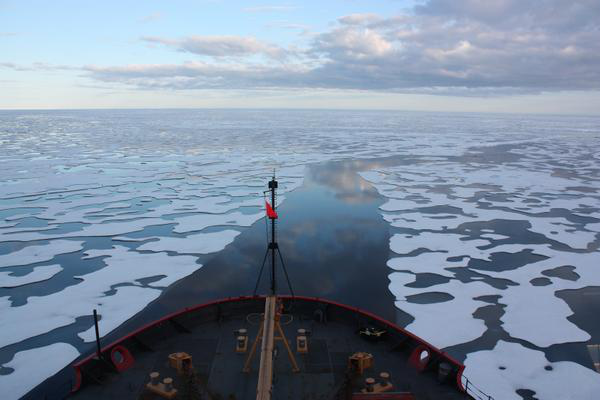

In [91]:
#showing a single image using the displayS3Image to show access to the S3 Bucket Imagery used for classification
displayS3Image('635765061391384576')

In [ ]:
# will show sample images from the twitter feed classified as hard hats and write out their geo coordinates
plotSaveSample()